# Voice Identification

### n-shot learning

The idea of one shot learning is to train an algorithm so that after only `n` examples, an algorithm can identify a example again. 

Siamese networks attempt to do this by training a model to learn how to take a high dimensional input an generate a feature vector. The network is trained by taking two examples either similar or different and training them to reduce/increase the distance of the feature vector generated by the output.

### Applying to Voice Identification

The end goal of this model is to take a audio sample that has undergone speech diarihsation and identify each speaker in the set.

### Datasets

| Name | Speakers           | Min  | Max
| ------------- |-------------|-----|-----|
[VoxCeleb](http://www.robots.ox.ac.uk/~vgg/data/voxceleb/)| 7000+| 3s | 3s
[10 English Speakers](http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS) | 10 | ? | ? 

### Articles

- https://github.com/zdmc23/oneshot-audio/blob/master/OneShot.ipynb

In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.debugger import set_trace

In [2]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *
from torch import nn
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataAugmentation import *
np.random.seed(2)

## 10 Speakers

Lets get a feel for the architecture by creating it and training on a dataset that we know we can do well on using standard classification techiques

In [3]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))
untar_data(data_url, dest=data_folder)

PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [4]:
max_length = 5*16000 
tfm_params = {
    'max_to_pad':max_length,
    'use_spectro':True, 
    'cache_spectro':True, 
    'to_db_scale':True,
    'f_max': 135
}
label_pattern = r'_([mf]\d+)_'
audios = AudioList.from_folder(data_folder, **tfm_params).split_none().label_from_re(label_pattern)
audios.train.x.tfm_args = tfm_params
audios.valid.x.tfm_args = tfm_params

## Data Loading

Generic for any size number of tuple meaning that experiments with Triplet Loss are possible

In [5]:
class ItemTuple(ItemBase):
    
    def __init__(self, items):
        # Warn if the items gets larger than intended
        self.size = len(items) 
        self.items = items
        self.data = torch.cat([x.data.unsqueeze(0) for x in items])
    
    def show(self):
        [x.show() for x in self.items]
        
    def apply_tfms(self, tfms):
        for tfm in tfms:
            self.data = torch.stack([tfm(x) for x in self.data])
        return self
    
    def __repr__(self):
        return ''.join([str(x) for x in self.items]) + '\n'
    
    def __len__(self):
        return self.size

In [6]:
class SiameseList(ItemList):
    
    def __init__(self, *args, open_fn=lambda x:x, **kwargs):
        super().__init__(*args, **kwargs)
        self.open = open_fn
        
    def get(self, i):
        item = super().get(i)
        if isinstance(item, ItemTuple):
            return item
        return ItemTuple([self.open(x) for x in item])

In [7]:
from copy import deepcopy

class SiameseDataset(LabelList):
    
    def show_similar(self):
        pass
        
    def show_different(self):
        pass
    
    @classmethod
    def from_label_list(cls, ll:LabelList, hidden_classes=None, train_num=20, valid_num=10):
        # Use random chunk of the classes for validation if none specified
        if hidden_classes is None: hidden_classes = list(range(ll.c))[-int(ll.c*0.2)]
        
        if hasattr(hidden_classes[0], 'data'):
            hidden_classes = [x.data for x in hidden_classes]

        if len(hidden_classes) < 2:
            raise Exception("Must be atleast 2 classes")
        
        # 
        train_cls = [i for i in range(ll.c - 1) if i not in hidden_classes]
        
        def mask(i,c): i.y.items == c
        
        # Copy to get transforms
        tll = deepcopy(ll)
        # Generate Items and Labels
        tll.x.items = np.concatenate([ll.x.items[mask(ll,c)] for c in train_cls])
        tll.y.items = np.concatenate([ll.y.items[mask(ll,c)] for c in train_cls])
        
        vll = deepcopy(ll)        
        vll.x.items = np.concatenate([ll.x.items[mask(ll,c)] for c in hidden_classes])
        vll.y.items = np.concatenate([ll.y.items[mask(ll,c)] for c in hidden_classes])
        
        tll = cls._from_label_list(tll, train_num, train_num//2)
        vll = cls._from_label_list(vll, valid_num, valid_num//2)
        return LabelLists(ll.x.path, tll, vll)
    
    @classmethod    
    def _from_label_list(cls, ll:LabelList, num_same=20, num_diff=30):
        x = ll.x
        y = ll.y
        # Seperate into lists of individual classes
        # Some of these may be empty because of the spit
        seperated = [x.items[y.items==c] for c in range(ll.c) if len(x.items[y.items==c]) > 0]
        
        # Create sets of same pairs
        # TODO Don't create the same pairs
        same_pairs = np.empty((0,2))
        for cis in seperated:
            r = np.array([np.random.choice(cis, num_same), np.random.choice(cis, num_same)]).T
            same_pairs = np.concatenate([same_pairs, r])
        
        # Create pairs of different items
        diff_pairs = np.empty((0,2))

        for i, cis in enumerate(seperated):
            other = [k for k in range(len(seperated)) if k != i]
            for i in other:
                ocis = seperated[i]
                dps = np.array([np.random.choice(cis, num_diff), np.random.choice(ocis, num_diff)]).T
                diff_pairs = np.concatenate([diff_pairs, dps])
        
        # Combine together 
        al = np.concatenate([same_pairs, diff_pairs])
        # Generate labels
        labels = np.concatenate([np.ones(len(same_pairs), dtype=np.int8), np.zeros(len(diff_pairs), dtype=np.int8)])
        
        inst = cls(SiameseList(al, open_fn=ll.x.open), CategoryList(labels, ['different', 'similar']))
        return inst
    

In [8]:
# We choose to keep one of each gender hidden in our validation set
sd = SiameseDataset.from_label_list(audios.train, [0, 6], 100, 100)
sd.train.x.tfm_args = tfm_params
sd.valid.x.tfm_args = tfm_params
tfm_sg_shift.use_on_y = False # Library broken
tfm_sg_aug.use_on_y = False # Library broken
tfms = [tfm_sg_shift, tfm_sg_aug], []

data = sd.transform(tfms).databunch(bs=30)

different


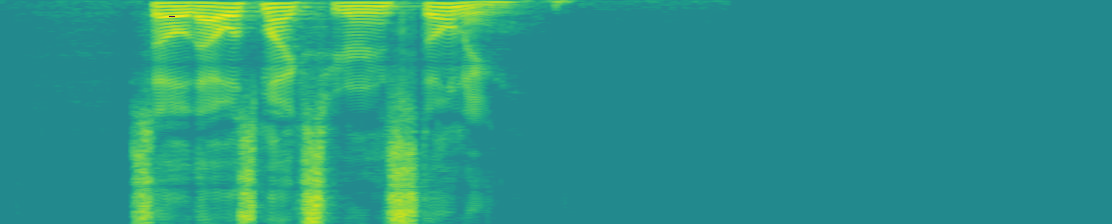

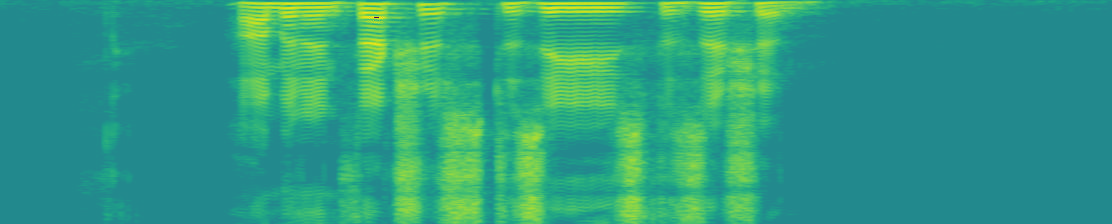

In [9]:
x, y = data.train_ds[-159]
print(y)
x.show()


Now that we have the data laoded and paired up, we can start to see whether the torch module that we've created works with the data we have.

In [10]:
class SiameseNetwork(nn.Module):
    
    def __init__(self, encoder=models.resnet18, s_out=512):
        # TODO warn is s_out is to large
        super().__init__()
        self.body = create_body(encoder, cut=-2)
        self.head = create_head(1024, 1, [s_out])[:5]
        
    def forward(self, items):
        # Get the batch size in the correct place
        ins = items.transpose(1, 0)
        outs = [self.body(x)  for x in ins]
        outs = [self.head(x) for x in outs]
        outs = torch.stack(outs)
        return torch.sigmoid(outs)


## Loss Functions

In [ ]:
def hinge_loss(x, y, m=1):
    # Was getting autograd errors if I didn't clone
    diff = torch.sqrt(torch.pow(x[0]-x[1], 2)).clone()**2
    diff[y==0] = m**2 - diff[y==0]
    diff[diff < 0] = 0
    return diff

def gen_loss_m(loss_func):
    return lambda x,y: loss_func(x, y).mean()

def loss_less_acc(loss_func, l):
    return lambda x,y: (loss_func(x,y) < l**2).float().mean()

def create_loss_acc(loss_func, l):
    return gen_loss_m(loss_func), loss_less_acc(loss_func, l)

## Creating a Learner

Here we create a loss function and accuracy metric to help track how many of the items in the
validation set are below the threshold number as the loss is continous 

In [21]:
def siamese_learner(data: DataBunch, encoder:nn.Module=models.resnet18, s_out=512, loss_func=None, loss_size=None, m=3):
    if loss_func is None: loss_func = partial(hinge_loss, m=m)
    # m/2 is the middle of confidence so if we're bellow it that means we've guessed correctly
    # although with very low confidence
    if loss_size is None: loss_size = m/2
    loss, acc = create_loss_acc(loss_func, loss_size)
    learner = Learner(data, SiameseNetwork(encoder, s_out), loss_func=loss, metrics=acc)
    learner.encode = lambda x: x # TODO create a simple way to get a vector of a piece of data
    return learner    

# Here we decide the length of the output vector. 
# This will be dependent on your encoder arch (bigger means bigger s_out)
learn = siamese_learner(data, encoder=models.resnet18, s_out=256, m=4)

# Audio Specific
learn.model.body[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).cuda()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


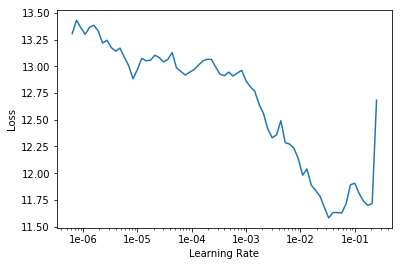

In [22]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,,time
0,7.514825,4.716863,0.636947,01:40
1,4.430785,3.154582,0.754177,01:40
2,4.164961,3.223039,0.740847,01:40
3,4.460588,3.483723,0.740970,01:40
4,4.290677,3.488923,0.733654,01:40
5,4.301899,3.958421,0.711709,01:40
6,4.191402,3.378440,0.752641,01:39
7,3.788911,3.875952,0.703810,01:40
8,4.043233,3.120146,0.756060,01:40
9,3.552018,2.865146,0.779080,01:40


# TODO

- More reasonable split of validation and training set
- Duplicate pairs potentially being added.
- Use on image problem
- Show predictions
- Compare the results of having k classes with n examples of a specific class